In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.regularizers import l1_l2
from keras.models import Model, clone_model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Concatenate, Activation, Subtract, merge, Reshape, UpSampling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import backend as K
from keras import optimizers
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook
from os import listdir
from os.path import isfile, join
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline

Using TensorFlow backend.


In [2]:
stickyPath = "../dataset/seen-dataset/TrainingSet/"
seenData = [f for f in listdir(stickyPath) if isfile(join(stickyPath, f))]
testData = [f for f in listdir("../dataset/seen-dataset/ValidationSet/") if isfile(join("../dataset/seen-dataset/ValidationSet/", f))]

In [3]:
trainData = seenData[0:int(len(seenData)*0.9)]
valData = seenData[int(len(seenData)*0.9):]

In [134]:
feature_data = pd.read_csv("../dataset/15features.csv")

In [135]:
feature_data.head()

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


In [136]:
cat_dict = {}
for idx,columns in enumerate(feature_data.columns):
    if columns != "imagename":
        cat_dict[idx]=len(np.unique(feature_data[columns]))
cat_dict

{1: 2,
 2: 3,
 3: 3,
 4: 3,
 5: 2,
 6: 2,
 7: 4,
 8: 2,
 9: 2,
 10: 4,
 11: 2,
 12: 3,
 13: 4,
 14: 2,
 15: 2}

In [137]:
train_features = feature_data[feature_data["imagename"].isin(trainData)]
for idx,columns in enumerate(train_features.columns):
    if columns != "imagename":
        train_features[str(columns)] = train_features[str(columns)] - 1
        train_features[str(columns)] = list(to_categorical(train_features[str(columns)],num_classes=cat_dict[idx]))

/home/ubuntu/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [138]:
val_features = feature_data[feature_data["imagename"].isin(valData)]
for idx,columns in enumerate(val_features.columns):
    if columns != "imagename":
        val_features[str(columns)] = val_features[str(columns)] - 1
        val_features[str(columns)] = list(to_categorical(val_features[str(columns)],num_classes=cat_dict[idx]))


/home/ubuntu/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [139]:
test_features = feature_data[feature_data["imagename"].isin(testData)]
test_features_normal = feature_data[feature_data["imagename"].isin(testData)]
for idx,columns in enumerate(test_features.columns):
    if columns != "imagename":
        test_features[str(columns)] = test_features[str(columns)] - 1
        test_features_normal[str(columns)] = test_features_normal[str(columns)] - 1
        test_features[str(columns)] = list(to_categorical(test_features[str(columns)],num_classes=cat_dict[idx]))

/home/ubuntu/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ubuntu/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [201]:
def datagen(batchSize,train_features,stickyPath):
    idx = 0
    hshift = (-64,64)
    vshift = (-64,64)
    while(True):
        subset = train_features.sample(n=batchSize).reset_index(drop=True)
        data = list(subset.imagename)
        returnInput=[]
        returnOutput=[]
        f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
        for image in data:
            skeleton = []
            left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
            #right = data.iloc[row,1]
            #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)
            
            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            #rightImage = right.astype('float32')
            #rightImage /= 255
            
            temp=[leftImage]

            skeleton.append(temp)
            
            features = train_features[train_features.imagename == image].iloc[:,1:].values
            f1.append(np.array(features[0][0],dtype='int32').tolist())
            f2.append(np.array(features[0][1],dtype='int32').tolist())
            f3.append(np.array(features[0][2],dtype='int32').tolist())
            f4.append(np.array(features[0][3],dtype='int32').tolist())
            f5.append(np.array(features[0][4],dtype='int32').tolist())
            f6.append(np.array(features[0][5],dtype='int32').tolist())
            f7.append(np.array(features[0][6],dtype='int32').tolist())
            f8.append(np.array(features[0][7],dtype='int32').tolist())
            f9.append(np.array(features[0][8],dtype='int32').tolist())
            f10.append(np.array(features[0][9],dtype='int32').tolist())
            f11.append(np.array(features[0][10],dtype='int32').tolist())
            f12.append(np.array(features[0][11],dtype='int32').tolist())
            f13.append(np.array(features[0][12],dtype='int32').tolist())
            f14.append(np.array(features[0][13],dtype='int32').tolist())
            f15.append(np.array(features[0][14],dtype='int32').tolist())
            
            # Shifting
            randH = np.random.randint(hshift[0],hshift[1])
            randV = np.random.randint(vshift[0],vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            #rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            #rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)
            
            temp = [leftImageShiftedV]
            skeleton.append(temp)
            f1.append(np.array(features[0][0],dtype='int32').tolist())
            f2.append(np.array(features[0][1],dtype='int32').tolist())
            f3.append(np.array(features[0][2],dtype='int32').tolist())
            f4.append(np.array(features[0][3],dtype='int32').tolist())
            f5.append(np.array(features[0][4],dtype='int32').tolist())
            f6.append(np.array(features[0][5],dtype='int32').tolist())
            f7.append(np.array(features[0][6],dtype='int32').tolist())
            f8.append(np.array(features[0][7],dtype='int32').tolist())
            f9.append(np.array(features[0][8],dtype='int32').tolist())
            f10.append(np.array(features[0][9],dtype='int32').tolist())
            f11.append(np.array(features[0][10],dtype='int32').tolist())
            f12.append(np.array(features[0][11],dtype='int32').tolist())
            f13.append(np.array(features[0][12],dtype='int32').tolist())
            f14.append(np.array(features[0][13],dtype='int32').tolist())
            f15.append(np.array(features[0][14],dtype='int32').tolist())
            
            
            temp = [leftImageShiftedH]
            skeleton.append(temp)
            
            f1.append(np.array(features[0][0],dtype='int32').tolist())
            f2.append(np.array(features[0][1],dtype='int32').tolist())
            f3.append(np.array(features[0][2],dtype='int32').tolist())
            f4.append(np.array(features[0][3],dtype='int32').tolist())
            f5.append(np.array(features[0][4],dtype='int32').tolist())
            f6.append(np.array(features[0][5],dtype='int32').tolist())
            f7.append(np.array(features[0][6],dtype='int32').tolist())
            f8.append(np.array(features[0][7],dtype='int32').tolist())
            f9.append(np.array(features[0][8],dtype='int32').tolist())
            f10.append(np.array(features[0][9],dtype='int32').tolist())
            f11.append(np.array(features[0][10],dtype='int32').tolist())
            f12.append(np.array(features[0][11],dtype='int32').tolist())
            f13.append(np.array(features[0][12],dtype='int32').tolist())
            f14.append(np.array(features[0][13],dtype='int32').tolist())
            f15.append(np.array(features[0][14],dtype='int32').tolist())
            
            returnInput.append(skeleton)
            

            
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(batchSize*3,64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,3)
        
        outList = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]

        for idx,item in enumerate(outList):
            outList[idx] = np.array(item)
        
        yield returnInput,outList
        
def testvalgen(batchSize,train_features,stickyPath):
    idx = 0
    hshift = (-64,64)
    vshift = (-64,64)
    while(True):
        subset = train_features.sample(frac=1).reset_index(drop=True)
        data = list(subset.imagename)
        returnInput=[]
        returnOutput=[]
        f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
        for image in data:
            skeleton = []
            left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
            #right = data.iloc[row,1]
            #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)
            
            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            #rightImage = right.astype('float32')
            #rightImage /= 255
            
            temp=[leftImage]

            skeleton.append(temp)
            
            features = train_features[train_features.imagename == image].iloc[:,1:].values
            f1.append(np.array(features[0][0],dtype='int32').tolist())
            f2.append(np.array(features[0][1],dtype='int32').tolist())
            f3.append(np.array(features[0][2],dtype='int32').tolist())
            f4.append(np.array(features[0][3],dtype='int32').tolist())
            f5.append(np.array(features[0][4],dtype='int32').tolist())
            f6.append(np.array(features[0][5],dtype='int32').tolist())
            f7.append(np.array(features[0][6],dtype='int32').tolist())
            f8.append(np.array(features[0][7],dtype='int32').tolist())
            f9.append(np.array(features[0][8],dtype='int32').tolist())
            f10.append(np.array(features[0][9],dtype='int32').tolist())
            f11.append(np.array(features[0][10],dtype='int32').tolist())
            f12.append(np.array(features[0][11],dtype='int32').tolist())
            f13.append(np.array(features[0][12],dtype='int32').tolist())
            f14.append(np.array(features[0][13],dtype='int32').tolist())
            f15.append(np.array(features[0][14],dtype='int32').tolist())
            
            returnInput.append(skeleton)
            

            
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(len(train_features)*1,64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,3)
        
        outList = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]

        for idx,item in enumerate(outList):
            outList[idx] = np.array(item)
        
        yield returnInput,outList
    

In [308]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
encoded = Dense(8*8*8, activation='relu', name='latent')(encoded)
# model = Model(input_img,encoded)
# print(model.summary())
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(r)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='RMSprop', loss='binary_crossentropy')

#display(SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))


In [309]:
autoencoder.load_weights("weights/simple_ae_maxpool_Seen_weights_v1.h5")

In [310]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('latent').output)

In [311]:
#display(SVG(model_to_dot(encoder, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

### Frezzing weights

In [312]:
for layer in encoder.layers:
    layer.trainable = True

In [313]:
_input = encoder.output
# Feature1
layerf1 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
layerf1 = BatchNormalization()(layerf1)

# Feature2
layerf2 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf2 = BatchNormalization()(layerf2)
#layerf2 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf2)
layerf2 = BatchNormalization()(layerf2)

# Feature3
layerf3 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
layerf3 = BatchNormalization()(layerf3)

# Feature4
layerf4 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf4 = BatchNormalization()(layerf4)
#layerf4 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf4)
layerf4 = BatchNormalization()(layerf4)

# Feature5
layerf5_c = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf5_c = BatchNormalization()(layerf5_c)
#layerf5_c = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf5_c)
layerf5 = BatchNormalization()(layerf5_c)

# Feature6
layerf6 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf6 = BatchNormalization()(layerf6)
#layerf6 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf6)
#layerf6 = Concatenate()([layerf6,layerf5_c])
layerf6 = BatchNormalization()(layerf6)

# Feature7
layerf7_c = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf7_c = BatchNormalization()(layerf7_c)
#layerf7_c = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf7_c)
layerf7 = BatchNormalization()(layerf7_c)

# Feature8
layerf8 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf8 = BatchNormalization()(layerf8)
#layerf8 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf8)
#layerf8 = Concatenate()([layerf8,layerf7_c])
layerf8 = BatchNormalization()(layerf8)

# Feature9
layerf9_c = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
layerf9 = BatchNormalization()(layerf9_c)

# Feature10
layerf10_c = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf10_c = BatchNormalization()(layerf10_c)
#layerf10_c = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf10_c)
layerf10 = BatchNormalization()(layerf10_c)

# Feature11
layerf11 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf11 = BatchNormalization()(layerf11)
#layerf11 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf11)
layerf11 = BatchNormalization()(layerf11)

# Feature12
layerf12 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf12 = BatchNormalization()(layerf12)
#layerf12 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf12)
#layerf12 = Concatenate()([layerf12,layerf10_c])
layerf12 = BatchNormalization()(layerf12)

# Feature13
layerf13 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf13 = Concatenate()([layerf13,layerf9_c])
layerf13 = BatchNormalization()(layerf13)

# Feature14
layerf14 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
layerf14 = BatchNormalization()(layerf14)

# Feature15
layerf15 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf15 = BatchNormalization()(layerf15)
#layerf15 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf15)
layerf15 = BatchNormalization()(layerf15)


layerOut1 = Dense(2,activation='softmax',name="pen_pressure",kernel_initializer="glorot_normal")(layerf1)
layerOut2 = Dense(3,activation='softmax',name="letter_spacing",kernel_initializer="glorot_normal")(layerf2)
layerOut3 = Dense(3,activation='softmax',name="size",kernel_initializer="glorot_normal")(layerf3)
layerOut4 = Dense(3,activation='softmax',name="dimension",kernel_initializer="glorot_normal")(layerf4)
layerOut5 = Dense(2,activation='softmax',name="is_lowercase",kernel_initializer="glorot_normal")(layerf5)
layerOut6 = Dense(2,activation='softmax',name="is_continuous",kernel_initializer="glorot_normal")(layerf6)
layerOut7 = Dense(4,activation='softmax',name="slantness",kernel_initializer="glorot_normal")(layerf7)
layerOut8 = Dense(2,activation='softmax',name="tilt",kernel_initializer="glorot_normal")(layerf8)
layerOut9 = Dense(2,activation='softmax',name="entry_stroke_a",kernel_initializer="glorot_normal")(layerf9)
layerOut10 = Dense(4,activation='softmax',name="staff_of_a",kernel_initializer="glorot_normal")(layerf10)
layerOut11 = Dense(2,activation='softmax',name="formation_n",kernel_initializer="glorot_normal")(layerf11)
layerOut12 = Dense(3,activation='softmax',name="staff_of_d",kernel_initializer="glorot_normal")(layerf12)
layerOut13 = Dense(4,activation='softmax',name="exit_stroke_d",kernel_initializer="glorot_normal")(layerf13)
layerOut14 = Dense(2,activation='softmax',name="word_formation",kernel_initializer="glorot_normal")(layerf14)
layerOut15 = Dense(2,activation='softmax',name="constancy",kernel_initializer="glorot_normal")(layerf15)

In [314]:
xai_NN = Model(encoder.input,[layerOut1,layerOut2,layerOut3,layerOut4,layerOut5,
                                 layerOut6,layerOut7,layerOut8,layerOut9,layerOut10,
                                layerOut11,layerOut12,layerOut13,layerOut14,layerOut15])

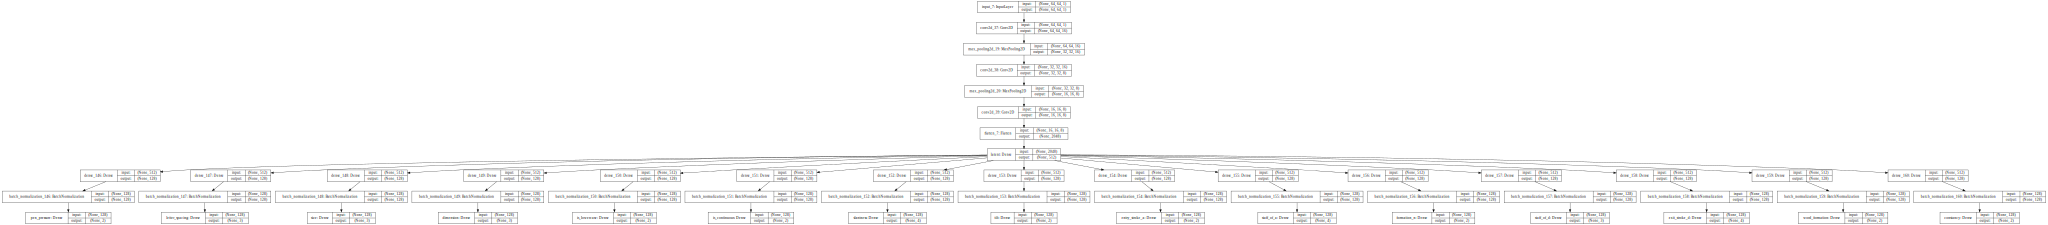

In [315]:
display(SVG(model_to_dot(xai_NN, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

In [316]:
lossesDict = {}
for idx,column in enumerate(train_features.columns):
    if idx  != 0:
        lossesDict[columns] = "categorical_crossentropy"

rmsProp = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
xai_NN.compile(optimizer=rmsProp, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [317]:
batchSize=25
trainGenObj = datagen(batchSize,train_features,stickyPath)
valGenObj = testvalgen(len(val_features),val_features,stickyPath)
testGenObj = testvalgen(len(test_features),test_features,"../dataset/seen-dataset/ValidationSet/")

In [318]:
LOG_DIR = './log/xai/seen'
#runIter = 0

In [319]:
mc = ModelCheckpoint(filepath='weights/xai_mulltitask_seen_weights_v1.h5', 
                     monitor='val_loss',period=1,save_best_only=True,
                     save_weights_only=True,mode='auto',verbose=1)
es = EarlyStopping(patience=75, monitor='val_loss', min_delta=0.0005, mode='auto')
tbCallBack = TensorBoard(log_dir=str(LOG_DIR+"/run"+str(runIter)), histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)
runIter+=1

In [293]:
# ((len(trainData)//batchSize)*3)

In [320]:
xai_NN.fit_generator(
    trainGenObj,
    epochs=100,
    verbose=2,
    validation_data=valGenObj,
    validation_steps=1,
    steps_per_epoch=((len(trainData)//batchSize)*3),
    callbacks=[es,tbCallBack,mc]
)

Epoch 1/100
 - 117s - loss: 8.9101 - pen_pressure_loss: 0.3574 - letter_spacing_loss: 0.9392 - size_loss: 0.6202 - dimension_loss: 0.6597 - is_lowercase_loss: 0.0702 - is_continuous_loss: 0.4027 - slantness_loss: 0.8207 - tilt_loss: 0.4866 - entry_stroke_a_loss: 0.1566 - staff_of_a_loss: 1.0374 - formation_n_loss: 0.4291 - staff_of_d_loss: 0.6790 - exit_stroke_d_loss: 1.0366 - word_formation_loss: 0.6099 - constancy_loss: 0.6047 - pen_pressure_categorical_accuracy: 0.8371 - letter_spacing_categorical_accuracy: 0.5520 - size_categorical_accuracy: 0.7226 - dimension_categorical_accuracy: 0.7119 - is_lowercase_categorical_accuracy: 0.9821 - is_continuous_categorical_accuracy: 0.8238 - slantness_categorical_accuracy: 0.6475 - tilt_categorical_accuracy: 0.8066 - entry_stroke_a_categorical_accuracy: 0.9436 - staff_of_a_categorical_accuracy: 0.5875 - formation_n_categorical_accuracy: 0.7992 - staff_of_d_categorical_accuracy: 0.7309 - exit_stroke_d_categorical_accuracy: 0.5485 - word_formation


Epoch 00004: val_loss improved from 12.63490 to 12.26157, saving model to weights/xai_mulltitask_seen_weights_v1.h5
Epoch 5/100
 - 99s - loss: 7.5642 - pen_pressure_loss: 0.3118 - letter_spacing_loss: 0.8951 - size_loss: 0.5635 - dimension_loss: 0.6043 - is_lowercase_loss: 0.0280 - is_continuous_loss: 0.2740 - slantness_loss: 0.6962 - tilt_loss: 0.4563 - entry_stroke_a_loss: 0.0708 - staff_of_a_loss: 0.8924 - formation_n_loss: 0.3482 - staff_of_d_loss: 0.6009 - exit_stroke_d_loss: 0.7383 - word_formation_loss: 0.5438 - constancy_loss: 0.5406 - pen_pressure_categorical_accuracy: 0.8586 - letter_spacing_categorical_accuracy: 0.5785 - size_categorical_accuracy: 0.7550 - dimension_categorical_accuracy: 0.7397 - is_lowercase_categorical_accuracy: 0.9913 - is_continuous_categorical_accuracy: 0.8932 - slantness_categorical_accuracy: 0.6985 - tilt_categorical_accuracy: 0.8153 - entry_stroke_a_categorical_accuracy: 0.9752 - staff_of_a_categorical_accuracy: 0.6418 - formation_n_categorical_accu


Epoch 00008: val_loss improved from 9.92806 to 9.88765, saving model to weights/xai_mulltitask_seen_weights_v1.h5
Epoch 9/100
 - 99s - loss: 7.6172 - pen_pressure_loss: 0.2997 - letter_spacing_loss: 0.8934 - size_loss: 0.5501 - dimension_loss: 0.5854 - is_lowercase_loss: 0.0247 - is_continuous_loss: 0.2370 - slantness_loss: 0.6696 - tilt_loss: 0.4356 - entry_stroke_a_loss: 0.0585 - staff_of_a_loss: 0.8642 - formation_n_loss: 0.3267 - staff_of_d_loss: 0.9426 - exit_stroke_d_loss: 0.6775 - word_formation_loss: 0.5291 - constancy_loss: 0.5231 - pen_pressure_categorical_accuracy: 0.8674 - letter_spacing_categorical_accuracy: 0.5771 - size_categorical_accuracy: 0.7613 - dimension_categorical_accuracy: 0.7504 - is_lowercase_categorical_accuracy: 0.9921 - is_continuous_categorical_accuracy: 0.9093 - slantness_categorical_accuracy: 0.7134 - tilt_categorical_accuracy: 0.8179 - entry_stroke_a_categorical_accuracy: 0.9805 - staff_of_a_categorical_accuracy: 0.6547 - formation_n_categorical_accura


Epoch 00012: val_loss improved from 9.88765 to 8.42244, saving model to weights/xai_mulltitask_seen_weights_v1.h5
Epoch 13/100
 - 99s - loss: 7.0569 - pen_pressure_loss: 0.3006 - letter_spacing_loss: 0.8854 - size_loss: 0.5388 - dimension_loss: 0.5844 - is_lowercase_loss: 0.0204 - is_continuous_loss: 0.2271 - slantness_loss: 0.6676 - tilt_loss: 0.3959 - entry_stroke_a_loss: 0.0573 - staff_of_a_loss: 0.8248 - formation_n_loss: 0.3153 - staff_of_d_loss: 0.5401 - exit_stroke_d_loss: 0.6551 - word_formation_loss: 0.5209 - constancy_loss: 0.5233 - pen_pressure_categorical_accuracy: 0.8666 - letter_spacing_categorical_accuracy: 0.5882 - size_categorical_accuracy: 0.7651 - dimension_categorical_accuracy: 0.7523 - is_lowercase_categorical_accuracy: 0.9934 - is_continuous_categorical_accuracy: 0.9141 - slantness_categorical_accuracy: 0.7119 - tilt_categorical_accuracy: 0.8344 - entry_stroke_a_categorical_accuracy: 0.9811 - staff_of_a_categorical_accuracy: 0.6712 - formation_n_categorical_accur


Epoch 00016: val_loss did not improve from 8.42244
Epoch 17/100
 - 99s - loss: 6.8718 - pen_pressure_loss: 0.3010 - letter_spacing_loss: 0.8681 - size_loss: 0.5278 - dimension_loss: 0.5798 - is_lowercase_loss: 0.0194 - is_continuous_loss: 0.2261 - slantness_loss: 0.6617 - tilt_loss: 0.3732 - entry_stroke_a_loss: 0.0560 - staff_of_a_loss: 0.8084 - formation_n_loss: 0.3031 - staff_of_d_loss: 0.4767 - exit_stroke_d_loss: 0.6431 - word_formation_loss: 0.5152 - constancy_loss: 0.5121 - pen_pressure_categorical_accuracy: 0.8650 - letter_spacing_categorical_accuracy: 0.5953 - size_categorical_accuracy: 0.7722 - dimension_categorical_accuracy: 0.7567 - is_lowercase_categorical_accuracy: 0.9932 - is_continuous_categorical_accuracy: 0.9156 - slantness_categorical_accuracy: 0.7158 - tilt_categorical_accuracy: 0.8436 - entry_stroke_a_categorical_accuracy: 0.9824 - staff_of_a_categorical_accuracy: 0.6796 - formation_n_categorical_accuracy: 0.8640 - staff_of_d_categorical_accuracy: 0.8288 - exit_st


Epoch 00020: val_loss did not improve from 8.12444
Epoch 21/100
 - 99s - loss: 6.6863 - pen_pressure_loss: 0.2958 - letter_spacing_loss: 0.8815 - size_loss: 0.5224 - dimension_loss: 0.5582 - is_lowercase_loss: 0.0190 - is_continuous_loss: 0.2231 - slantness_loss: 0.6493 - tilt_loss: 0.3673 - entry_stroke_a_loss: 0.0503 - staff_of_a_loss: 0.7873 - formation_n_loss: 0.3013 - staff_of_d_loss: 0.4011 - exit_stroke_d_loss: 0.6180 - word_formation_loss: 0.5041 - constancy_loss: 0.5074 - pen_pressure_categorical_accuracy: 0.8689 - letter_spacing_categorical_accuracy: 0.5893 - size_categorical_accuracy: 0.7732 - dimension_categorical_accuracy: 0.7660 - is_lowercase_categorical_accuracy: 0.9934 - is_continuous_categorical_accuracy: 0.9159 - slantness_categorical_accuracy: 0.7213 - tilt_categorical_accuracy: 0.8454 - entry_stroke_a_categorical_accuracy: 0.9835 - staff_of_a_categorical_accuracy: 0.6899 - formation_n_categorical_accuracy: 0.8652 - staff_of_d_categorical_accuracy: 0.8541 - exit_st


Epoch 00024: val_loss did not improve from 8.12444
Epoch 25/100
 - 99s - loss: 6.5800 - pen_pressure_loss: 0.2960 - letter_spacing_loss: 0.8472 - size_loss: 0.5163 - dimension_loss: 0.5620 - is_lowercase_loss: 0.0177 - is_continuous_loss: 0.2151 - slantness_loss: 0.6460 - tilt_loss: 0.3467 - entry_stroke_a_loss: 0.0505 - staff_of_a_loss: 0.7717 - formation_n_loss: 0.2963 - staff_of_d_loss: 0.3866 - exit_stroke_d_loss: 0.6189 - word_formation_loss: 0.5084 - constancy_loss: 0.5006 - pen_pressure_categorical_accuracy: 0.8667 - letter_spacing_categorical_accuracy: 0.6130 - size_categorical_accuracy: 0.7770 - dimension_categorical_accuracy: 0.7624 - is_lowercase_categorical_accuracy: 0.9937 - is_continuous_categorical_accuracy: 0.9202 - slantness_categorical_accuracy: 0.7246 - tilt_categorical_accuracy: 0.8555 - entry_stroke_a_categorical_accuracy: 0.9843 - staff_of_a_categorical_accuracy: 0.6953 - formation_n_categorical_accuracy: 0.8691 - staff_of_d_categorical_accuracy: 0.8581 - exit_st


Epoch 00028: val_loss improved from 8.12444 to 8.09823, saving model to weights/xai_mulltitask_seen_weights_v1.h5
Epoch 29/100
 - 99s - loss: 6.4808 - pen_pressure_loss: 0.2876 - letter_spacing_loss: 0.8400 - size_loss: 0.5061 - dimension_loss: 0.5502 - is_lowercase_loss: 0.0169 - is_continuous_loss: 0.2138 - slantness_loss: 0.6370 - tilt_loss: 0.3414 - entry_stroke_a_loss: 0.0520 - staff_of_a_loss: 0.7676 - formation_n_loss: 0.2951 - staff_of_d_loss: 0.3717 - exit_stroke_d_loss: 0.6051 - word_formation_loss: 0.4961 - constancy_loss: 0.5003 - pen_pressure_categorical_accuracy: 0.8722 - letter_spacing_categorical_accuracy: 0.6142 - size_categorical_accuracy: 0.7809 - dimension_categorical_accuracy: 0.7694 - is_lowercase_categorical_accuracy: 0.9942 - is_continuous_categorical_accuracy: 0.9213 - slantness_categorical_accuracy: 0.7263 - tilt_categorical_accuracy: 0.8581 - entry_stroke_a_categorical_accuracy: 0.9841 - staff_of_a_categorical_accuracy: 0.6976 - formation_n_categorical_accur


Epoch 00032: val_loss did not improve from 8.00930
Epoch 33/100
 - 100s - loss: 6.4327 - pen_pressure_loss: 0.2898 - letter_spacing_loss: 0.8414 - size_loss: 0.5121 - dimension_loss: 0.5473 - is_lowercase_loss: 0.0174 - is_continuous_loss: 0.2097 - slantness_loss: 0.6360 - tilt_loss: 0.3412 - entry_stroke_a_loss: 0.0508 - staff_of_a_loss: 0.7543 - formation_n_loss: 0.2890 - staff_of_d_loss: 0.3623 - exit_stroke_d_loss: 0.5972 - word_formation_loss: 0.4913 - constancy_loss: 0.4928 - pen_pressure_categorical_accuracy: 0.8710 - letter_spacing_categorical_accuracy: 0.6172 - size_categorical_accuracy: 0.7804 - dimension_categorical_accuracy: 0.7718 - is_lowercase_categorical_accuracy: 0.9943 - is_continuous_categorical_accuracy: 0.9238 - slantness_categorical_accuracy: 0.7296 - tilt_categorical_accuracy: 0.8584 - entry_stroke_a_categorical_accuracy: 0.9842 - staff_of_a_categorical_accuracy: 0.7037 - formation_n_categorical_accuracy: 0.8718 - staff_of_d_categorical_accuracy: 0.8687 - exit_s


Epoch 00036: val_loss did not improve from 7.75190
Epoch 37/100
 - 99s - loss: 6.3297 - pen_pressure_loss: 0.2959 - letter_spacing_loss: 0.8300 - size_loss: 0.5089 - dimension_loss: 0.5463 - is_lowercase_loss: 0.0162 - is_continuous_loss: 0.2072 - slantness_loss: 0.6230 - tilt_loss: 0.3321 - entry_stroke_a_loss: 0.0484 - staff_of_a_loss: 0.7336 - formation_n_loss: 0.2835 - staff_of_d_loss: 0.3609 - exit_stroke_d_loss: 0.5805 - word_formation_loss: 0.4823 - constancy_loss: 0.4809 - pen_pressure_categorical_accuracy: 0.8677 - letter_spacing_categorical_accuracy: 0.6211 - size_categorical_accuracy: 0.7813 - dimension_categorical_accuracy: 0.7730 - is_lowercase_categorical_accuracy: 0.9947 - is_continuous_categorical_accuracy: 0.9231 - slantness_categorical_accuracy: 0.7347 - tilt_categorical_accuracy: 0.8612 - entry_stroke_a_categorical_accuracy: 0.9847 - staff_of_a_categorical_accuracy: 0.7113 - formation_n_categorical_accuracy: 0.8754 - staff_of_d_categorical_accuracy: 0.8701 - exit_st


Epoch 00040: val_loss did not improve from 7.58848
Epoch 41/100
 - 99s - loss: 6.2492 - pen_pressure_loss: 0.2948 - letter_spacing_loss: 0.8247 - size_loss: 0.4968 - dimension_loss: 0.5417 - is_lowercase_loss: 0.0158 - is_continuous_loss: 0.2075 - slantness_loss: 0.6210 - tilt_loss: 0.3267 - entry_stroke_a_loss: 0.0459 - staff_of_a_loss: 0.7276 - formation_n_loss: 0.2769 - staff_of_d_loss: 0.3453 - exit_stroke_d_loss: 0.5710 - word_formation_loss: 0.4761 - constancy_loss: 0.4773 - pen_pressure_categorical_accuracy: 0.8676 - letter_spacing_categorical_accuracy: 0.6266 - size_categorical_accuracy: 0.7866 - dimension_categorical_accuracy: 0.7722 - is_lowercase_categorical_accuracy: 0.9948 - is_continuous_categorical_accuracy: 0.9218 - slantness_categorical_accuracy: 0.7335 - tilt_categorical_accuracy: 0.8642 - entry_stroke_a_categorical_accuracy: 0.9856 - staff_of_a_categorical_accuracy: 0.7159 - formation_n_categorical_accuracy: 0.8776 - staff_of_d_categorical_accuracy: 0.8748 - exit_st


Epoch 00044: val_loss did not improve from 7.58848
Epoch 45/100
 - 100s - loss: 6.1602 - pen_pressure_loss: 0.2865 - letter_spacing_loss: 0.8177 - size_loss: 0.4954 - dimension_loss: 0.5315 - is_lowercase_loss: 0.0162 - is_continuous_loss: 0.2008 - slantness_loss: 0.6124 - tilt_loss: 0.3280 - entry_stroke_a_loss: 0.0459 - staff_of_a_loss: 0.7140 - formation_n_loss: 0.2714 - staff_of_d_loss: 0.3390 - exit_stroke_d_loss: 0.5606 - word_formation_loss: 0.4749 - constancy_loss: 0.4659 - pen_pressure_categorical_accuracy: 0.8722 - letter_spacing_categorical_accuracy: 0.6260 - size_categorical_accuracy: 0.7861 - dimension_categorical_accuracy: 0.7783 - is_lowercase_categorical_accuracy: 0.9952 - is_continuous_categorical_accuracy: 0.9259 - slantness_categorical_accuracy: 0.7411 - tilt_categorical_accuracy: 0.8629 - entry_stroke_a_categorical_accuracy: 0.9860 - staff_of_a_categorical_accuracy: 0.7240 - formation_n_categorical_accuracy: 0.8798 - staff_of_d_categorical_accuracy: 0.8758 - exit_s


Epoch 00048: val_loss did not improve from 7.58848
Epoch 49/100
 - 99s - loss: 6.0817 - pen_pressure_loss: 0.2838 - letter_spacing_loss: 0.8126 - size_loss: 0.4857 - dimension_loss: 0.5345 - is_lowercase_loss: 0.0143 - is_continuous_loss: 0.1960 - slantness_loss: 0.6081 - tilt_loss: 0.3199 - entry_stroke_a_loss: 0.0469 - staff_of_a_loss: 0.6998 - formation_n_loss: 0.2657 - staff_of_d_loss: 0.3263 - exit_stroke_d_loss: 0.5569 - word_formation_loss: 0.4677 - constancy_loss: 0.4637 - pen_pressure_categorical_accuracy: 0.8749 - letter_spacing_categorical_accuracy: 0.6328 - size_categorical_accuracy: 0.7919 - dimension_categorical_accuracy: 0.7773 - is_lowercase_categorical_accuracy: 0.9952 - is_continuous_categorical_accuracy: 0.9287 - slantness_categorical_accuracy: 0.7437 - tilt_categorical_accuracy: 0.8676 - entry_stroke_a_categorical_accuracy: 0.9857 - staff_of_a_categorical_accuracy: 0.7291 - formation_n_categorical_accuracy: 0.8836 - staff_of_d_categorical_accuracy: 0.8819 - exit_st


Epoch 00052: val_loss did not improve from 7.58848
Epoch 53/100
 - 99s - loss: 5.9858 - pen_pressure_loss: 0.2840 - letter_spacing_loss: 0.8048 - size_loss: 0.4802 - dimension_loss: 0.5158 - is_lowercase_loss: 0.0148 - is_continuous_loss: 0.1899 - slantness_loss: 0.5970 - tilt_loss: 0.3166 - entry_stroke_a_loss: 0.0404 - staff_of_a_loss: 0.6929 - formation_n_loss: 0.2636 - staff_of_d_loss: 0.3184 - exit_stroke_d_loss: 0.5471 - word_formation_loss: 0.4658 - constancy_loss: 0.4544 - pen_pressure_categorical_accuracy: 0.8756 - letter_spacing_categorical_accuracy: 0.6369 - size_categorical_accuracy: 0.7947 - dimension_categorical_accuracy: 0.7860 - is_lowercase_categorical_accuracy: 0.9954 - is_continuous_categorical_accuracy: 0.9306 - slantness_categorical_accuracy: 0.7471 - tilt_categorical_accuracy: 0.8685 - entry_stroke_a_categorical_accuracy: 0.9874 - staff_of_a_categorical_accuracy: 0.7328 - formation_n_categorical_accuracy: 0.8837 - staff_of_d_categorical_accuracy: 0.8861 - exit_st


Epoch 00056: val_loss did not improve from 7.58848
Epoch 57/100
 - 99s - loss: 5.8904 - pen_pressure_loss: 0.2755 - letter_spacing_loss: 0.7951 - size_loss: 0.4713 - dimension_loss: 0.5078 - is_lowercase_loss: 0.0143 - is_continuous_loss: 0.1886 - slantness_loss: 0.5981 - tilt_loss: 0.3158 - entry_stroke_a_loss: 0.0417 - staff_of_a_loss: 0.6713 - formation_n_loss: 0.2598 - staff_of_d_loss: 0.3082 - exit_stroke_d_loss: 0.5405 - word_formation_loss: 0.4545 - constancy_loss: 0.4478 - pen_pressure_categorical_accuracy: 0.8795 - letter_spacing_categorical_accuracy: 0.6428 - size_categorical_accuracy: 0.7995 - dimension_categorical_accuracy: 0.7898 - is_lowercase_categorical_accuracy: 0.9955 - is_continuous_categorical_accuracy: 0.9315 - slantness_categorical_accuracy: 0.7501 - tilt_categorical_accuracy: 0.8689 - entry_stroke_a_categorical_accuracy: 0.9872 - staff_of_a_categorical_accuracy: 0.7413 - formation_n_categorical_accuracy: 0.8867 - staff_of_d_categorical_accuracy: 0.8899 - exit_st


Epoch 00060: val_loss did not improve from 7.58848
Epoch 61/100
 - 99s - loss: 5.7574 - pen_pressure_loss: 0.2715 - letter_spacing_loss: 0.7797 - size_loss: 0.4630 - dimension_loss: 0.4955 - is_lowercase_loss: 0.0131 - is_continuous_loss: 0.1837 - slantness_loss: 0.5925 - tilt_loss: 0.3042 - entry_stroke_a_loss: 0.0383 - staff_of_a_loss: 0.6581 - formation_n_loss: 0.2577 - staff_of_d_loss: 0.2979 - exit_stroke_d_loss: 0.5276 - word_formation_loss: 0.4409 - constancy_loss: 0.4338 - pen_pressure_categorical_accuracy: 0.8815 - letter_spacing_categorical_accuracy: 0.6497 - size_categorical_accuracy: 0.8040 - dimension_categorical_accuracy: 0.7932 - is_lowercase_categorical_accuracy: 0.9956 - is_continuous_categorical_accuracy: 0.9337 - slantness_categorical_accuracy: 0.7507 - tilt_categorical_accuracy: 0.8748 - entry_stroke_a_categorical_accuracy: 0.9880 - staff_of_a_categorical_accuracy: 0.7476 - formation_n_categorical_accuracy: 0.8871 - staff_of_d_categorical_accuracy: 0.8936 - exit_st


Epoch 00064: val_loss did not improve from 7.58848
Epoch 65/100
 - 99s - loss: 5.6434 - pen_pressure_loss: 0.2678 - letter_spacing_loss: 0.7679 - size_loss: 0.4552 - dimension_loss: 0.4832 - is_lowercase_loss: 0.0127 - is_continuous_loss: 0.1828 - slantness_loss: 0.5751 - tilt_loss: 0.2960 - entry_stroke_a_loss: 0.0376 - staff_of_a_loss: 0.6540 - formation_n_loss: 0.2478 - staff_of_d_loss: 0.2878 - exit_stroke_d_loss: 0.5153 - word_formation_loss: 0.4351 - constancy_loss: 0.4248 - pen_pressure_categorical_accuracy: 0.8845 - letter_spacing_categorical_accuracy: 0.6553 - size_categorical_accuracy: 0.8083 - dimension_categorical_accuracy: 0.8009 - is_lowercase_categorical_accuracy: 0.9959 - is_continuous_categorical_accuracy: 0.9336 - slantness_categorical_accuracy: 0.7590 - tilt_categorical_accuracy: 0.8780 - entry_stroke_a_categorical_accuracy: 0.9881 - staff_of_a_categorical_accuracy: 0.7474 - formation_n_categorical_accuracy: 0.8910 - staff_of_d_categorical_accuracy: 0.8974 - exit_st


Epoch 00068: val_loss did not improve from 7.58848
Epoch 69/100
 - 99s - loss: 5.5316 - pen_pressure_loss: 0.2675 - letter_spacing_loss: 0.7520 - size_loss: 0.4465 - dimension_loss: 0.4768 - is_lowercase_loss: 0.0126 - is_continuous_loss: 0.1792 - slantness_loss: 0.5709 - tilt_loss: 0.2879 - entry_stroke_a_loss: 0.0372 - staff_of_a_loss: 0.6305 - formation_n_loss: 0.2405 - staff_of_d_loss: 0.2716 - exit_stroke_d_loss: 0.5051 - word_formation_loss: 0.4286 - constancy_loss: 0.4247 - pen_pressure_categorical_accuracy: 0.8851 - letter_spacing_categorical_accuracy: 0.6653 - size_categorical_accuracy: 0.8142 - dimension_categorical_accuracy: 0.8041 - is_lowercase_categorical_accuracy: 0.9956 - is_continuous_categorical_accuracy: 0.9356 - slantness_categorical_accuracy: 0.7602 - tilt_categorical_accuracy: 0.8840 - entry_stroke_a_categorical_accuracy: 0.9890 - staff_of_a_categorical_accuracy: 0.7593 - formation_n_categorical_accuracy: 0.8952 - staff_of_d_categorical_accuracy: 0.9037 - exit_st

KeyboardInterrupt: 

In [322]:
xai_NN.load_weights("weights/xai_mulltitask_seen_weights_v1.h5")

In [353]:
xai_NN.evaluate_generator(valGenObj,steps=1)

[7.588483810424805,
 0.28402742743492126,
 0.9204734563827515,
 0.6065825819969177,
 0.6906394958496094,
 0.048508524894714355,
 0.17433150112628937,
 0.793507993221283,
 0.49241167306900024,
 0.09550883620977402,
 0.8688187003135681,
 0.33451157808303833,
 0.4426412880420685,
 0.7064171433448792,
 0.5463104248046875,
 0.5837926268577576,
 0.8729150295257568,
 0.5909451842308044,
 0.7434471845626831,
 0.7077045440673828,
 0.9888800382614136,
 0.9483717083930969,
 0.683876097202301,
 0.8133439421653748,
 0.9714058637619019,
 0.677521824836731,
 0.8522636890411377,
 0.8665607571601868,
 0.7402700781822205,
 0.7275615334510803,
 0.7188244462013245]

In [325]:
output = xai_NN.predict_generator(testGenObj,steps=1)

pred = [[] for _ in range(15)]
for idx in range(15):
    pred[idx].append(np.argmax(output[idx],axis=1))

pred = np.array(pred)
pred = pred.T

pred = pred.reshape((len(pred),15))
predDF = pd.DataFrame(data = pred,columns=test_features.columns[1:])


In [329]:
observed = test_features_normal.iloc[:,1:].values.tolist()
observed = np.array(observed)
for idx in range(15):
    print("Feature " + str(idx)+str(precision_recall_fscore_support(pred[:,idx],observed[:,idx],average='weighted')))

Feature 0(0.562583409062066, 0.5360169491525424, 0.5460739963426039, None)
Feature 1(0.4291504580634487, 0.3908898305084746, 0.4036645336984134, None)
Feature 2(0.4796783975915816, 0.4300847457627119, 0.45080175322545163, None)
Feature 3(0.46843676194585154, 0.45338983050847464, 0.4589088624830639, None)
Feature 4(0.951636001087646, 0.9661016949152542, 0.9588142898889538, None)
Feature 5(0.5233050847457628, 0.5233050847457628, 0.5233050847457628, None)
Feature 6(0.39571873685445885, 0.3972457627118644, 0.3943971377403839, None)
Feature 7(0.9308674017293627, 0.8379237288135594, 0.87908469487709, None)
Feature 8(0.940677966101695, 0.940677966101695, 0.940677966101695, None)
Feature 9(0.5318940788340921, 0.45868644067796616, 0.4901349148221866, None)
Feature 10(0.7070412870608651, 0.698093220338983, 0.7024750797119886, None)
Feature 11(0.48213367740941576, 0.4459745762711864, 0.4619237319509754, None)
Feature 12(0.2974604613363909, 0.3008474576271186, 0.29823512272876485, None)
Feature 13